In [17]:
# =========================
# 01. SETUP & LOAD DATA
# =========================
import sys
from pathlib import Path
ROOT_DIR = Path().resolve().parents[0]
sys.path.append(str(ROOT_DIR))

import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from constants import DATA_URL


df = pd.read_csv(DATA_URL)
print("Total movies:", len(df))

Total movies: 7668


In [18]:
# =========================
# 02. DATA CLEANING
# =========================

# Standardize numeric columns
num_cols = ["budget", "gross", "votes", "score", "runtime", "year"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows without core financial data
if {"budget", "gross"}.issubset(df.columns):
    df = df.dropna(subset=["budget", "gross"])

# Fill missing numeric values
df = df.fillna(df.mean(numeric_only=True))

# -------------------------
# Standardize movie title column
# -------------------------
title_candidates = ["title", "movie", "movie_title", "name", "film"]

for c in title_candidates:
    if c in df.columns:
        df = df.rename(columns={c: "title"})
        break

In [19]:
# =========================
# 03. FEATURE ENGINEERING
# =========================

# Ensure numeric columns (CSV safety)
for col in ["gross", "budget", "runtime", "score", "votes"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill numeric NaNs to avoid crashes
df = df.fillna(df.mean(numeric_only=True))

# --- ROI ---
if {"gross", "budget"}.issubset(df.columns):
    df["ROI"] = (df["gross"] - df["budget"]) / df["budget"]

# --- CPM (Cost per Minute) ---
if {"budget", "runtime"}.issubset(df.columns):
    df["CPM"] = df["budget"] / df["runtime"]

# --- Engagement Proxy ---
if {"score", "votes"}.issubset(df.columns):
    df["Engagement"] = df["score"] * np.log(df["votes"])


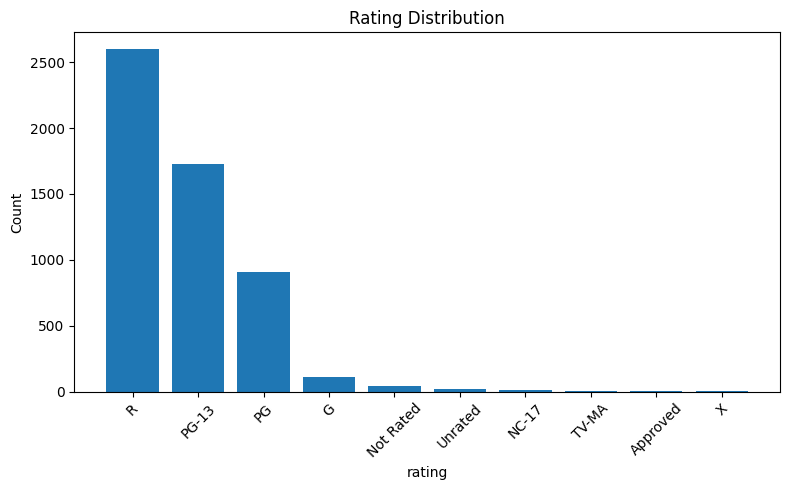

<Figure size 1400x600 with 0 Axes>

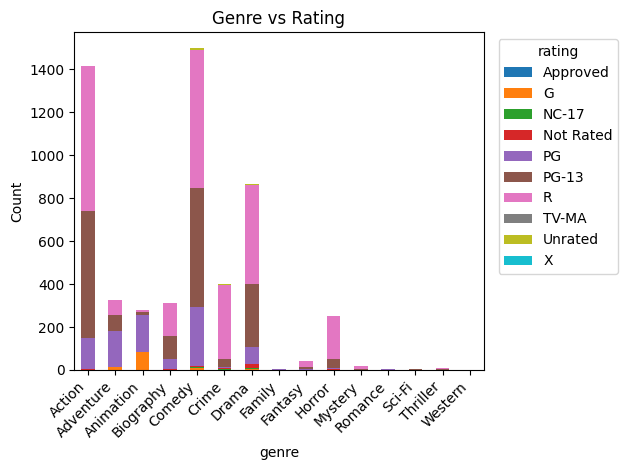

In [28]:
import pandas as pd
import matplotlib.pyplot as plt


rating_counts = df["rating"].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(rating_counts.index, rating_counts.values)

plt.title("Rating Distribution")
plt.xlabel("rating")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

genre_rating_counts = (
    df.groupby(["genre", "rating"])
      .size()
      .unstack(fill_value=0)
)

plt.figure(figsize=(14, 6))
genre_rating_counts.plot(kind="bar", stacked=True)

plt.title("Genre vs Rating")
plt.xlabel("genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="rating", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()




In [21]:
from pathlib import Path

def ensure_dir(path:str):
    Path(path).mkdir(parents=True, exist_ok=True)

BASE_DIR = "../data"

DIRS = [
    f"{BASE_DIR}/clean",
    f"{BASE_DIR}/overview",
    f"{BASE_DIR}/financial",
    f"{BASE_DIR}/market",
    f"{BASE_DIR}/trend",
    f"{BASE_DIR}/segmentation",
]

for d in DIRS:
    ensure_dir(d)

In [22]:
# =========================
# 18. EXPORT FOR STREAMLIT & PPT
# =========================

# Dataset clean
df.to_csv("../data/clean/movies_clean.csv", index=False)

# Slides 6 – Audience & Quality
df.groupby("genre", as_index=False)["score"].mean() \
  .to_csv("../data/audience/score_by_genre.csv", index=False)
df.groupby("rating", as_index=False)["score"].mean() \
  .to_csv("../data/audience/score_by_rating.csv", index=False)

# Slides 8–10 – Financial & ROI
df.groupby("genre", as_index=False)["ROI"].mean() \
  .to_csv("../data/financial/roi_by_genre.csv", index=False)
df.groupby("rating", as_index=False)["ROI"].mean() \
  .to_csv("../data/financial/roi_by_rating.csv", index=False)
top_bottom = pd.concat([
    df.sort_values("ROI", ascending=False).head(10).assign(type="Top"),
    df.sort_values("ROI").head(10).assign(type="Bottom")
])
top_bottom.to_csv("../data/financial/top_bottom_roi.csv", index=False)

# Slides 11–12 – Marketing & Engagement
df.groupby("genre", as_index=False)["CPM"].mean() \
  .to_csv("../data/marketing/cpm_by_genre.csv", index=False)
df.groupby("genre", as_index=False)["engagement"].mean() \
  .to_csv("../data/marketing/engagement_by_genre.csv", index=False)

# Slides 15–17 – Trend & Segmentation
df.groupby("year", as_index=False).agg(
    avg_budget=("budget", "mean"),
    avg_gross=("gross", "mean"),
    avg_ROI=("ROI", "mean")
).to_csv("../data/trend/yearly_trend.csv", index=False)
df[["title", "genre", "budget", "gross", "ROI", "segment"]] \
  .to_csv("../data/segmentation/movie_segments.csv", index=False)

OSError: Cannot save file into a non-existent directory: '..\data\audience'